In [2]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:

def load_mesh_from_folder(remeshed_path, clipped_path):
    """Load mesh data from a folder containing remeshed and clipped samples.
    Args:
        remeshed_path (str): Path to the folder containing remeshed samples.
        clipped_path (str): Path to the folder containing clipped samples.
    Returns:
        list: A list of tuples containing (remeshed_mesh_path, clipped_mesh_path).
    """
    mesh_pairs = []
    for samples_name in sorted(os.listdir(remeshed_path)):
        if not samples_name.startswith('sample_'):
            continue
            
        remeshed_mesh_dir = os.path.join(remeshed_path, samples_name, 'meshes')
        clipped_mesh_dir = os.path.join(clipped_path, samples_name, 'meshes')
        
        if not os.path.isdir(remeshed_mesh_dir) or not os.path.isdir(clipped_mesh_dir):
            continue 
            
        remeshed_mesh = os.path.join(remeshed_mesh_dir, 'mesh_000000000.cgns') 
        clipped_mesh = os.path.join(clipped_mesh_dir, 'mesh_000000000.cgns')
        
        if os.path.isfile(remeshed_mesh) and os.path.isfile(clipped_mesh):
            mesh_pairs.append((remeshed_mesh, clipped_mesh))
            print(f"✅ Found mesh pair: {samples_name}")
    
    return mesh_pairs

data_remeshed_path = './AirfRANS_remeshed'
data_clipped_path = './AirfRANS_clipped'

mesh_paths = load_mesh_from_folder(data_clipped_path, data_remeshed_path) 
print(f"Found {len(mesh_paths)} mesh pairs.")

✅ Found mesh pair: sample_000000000
✅ Found mesh pair: sample_000000010
✅ Found mesh pair: sample_000000020
✅ Found mesh pair: sample_000000030
✅ Found mesh pair: sample_000000040
✅ Found mesh pair: sample_000000050
✅ Found mesh pair: sample_000000100
✅ Found mesh pair: sample_000000300
✅ Found mesh pair: sample_000000500
✅ Found mesh pair: sample_000000750
✅ Found mesh pair: sample_000000999
Found 11 mesh pairs.


In [ ]:
def process_mesh_pair(remeshed_path, clipped_path ):
    """
    Process a pair of remeshed and clipped meshes with consistent scaling
    Args:
        remeshed_path (str): Path to remeshed mesh file
        clipped_path (str): Path to clipped mesh file   
    Returns:
        tuple: (remeshed_data, clipped_data, global_ranges) for consistent scaling
    """
    
    def extract_mesh_data(filepath, mesh_type):
        """Extract data from a single mesh file"""
        print(f"\nProcessing {mesh_type} mesh: {os.path.basename(filepath)}")
        
        # Read the mesh
        reader = pv.CGNSReader(filepath)
        reader.load_boundary_patch = False
        mesh = reader.read().combine()
        
        # Get bounds and create sampling plane
        bounds = mesh.bounds
        x_min, x_max, y_min, y_max, z_min, z_max = bounds
        resolution = 512
        
        plane = pv.Plane(center=[(x_min + x_max)/2, (y_min + y_max)/2, 0], 
                        direction=[0, 0, 1], 
                        i_size=x_max - x_min, 
                        j_size=y_max - y_min, 
                        i_resolution=resolution, 
                        j_resolution=resolution)
        
        # Sample the data
        sampled_mesh = plane.sample(mesh)
        n_points = sampled_mesh.n_points
        actual_resolution = int(np.sqrt(n_points))
        
        print(f"  Available arrays: {sampled_mesh.array_names}")
        print(f"  Resolution: {actual_resolution}x{actual_resolution}")
        
        # Extract data arrays
        data_dict = {}
        for array_name in ['nut', 'p', 'Ux', 'Uy', 'implicit_distance']:
            if array_name in sampled_mesh.array_names:
                data = sampled_mesh[array_name]
                
                # Reshape data
                if len(data) == actual_resolution * actual_resolution:
                    data = data.reshape(actual_resolution, actual_resolution)
                else:
                    # Interpolate to regular grid
                    from scipy.interpolate import griddata
                    points = sampled_mesh.points
                    x, y = points[:, 0], points[:, 1]
                    xi = np.linspace(x.min(), x.max(), resolution)
                    yi = np.linspace(y.min(), y.max(), resolution)
                    Xi, Yi = np.meshgrid(xi, yi)
                    data = griddata((x, y), data, (Xi, Yi), method='linear')
                
                data_dict[array_name] = data
                print(f"  {array_name}: range [{np.nanmin(data):.6f}, {np.nanmax(data):.6f}]")
        
        return data_dict, bounds
    
    # Process both meshes
    remeshed_data, remeshed_bounds = extract_mesh_data(remeshed_path, "REMESHED")
    clipped_data, clipped_bounds = extract_mesh_data(clipped_path, "CLIPPED")
    
    # Calculate global ranges for consistent scaling
    global_ranges = {}
    for var in ['nut', 'p', 'Ux', 'Uy']:
        if var in remeshed_data and var in clipped_data:
            # Find global min/max across both meshes
            remeshed_vals = remeshed_data[var]
            clipped_vals = clipped_data[var]
            
            global_min = min(np.nanmin(remeshed_vals), np.nanmin(clipped_vals))
            global_max = max(np.nanmax(remeshed_vals), np.nanmax(clipped_vals))
            
            global_ranges[var] = (global_min, global_max)
            print(f"\nGlobal range for {var}: [{global_min:.6f}, {global_max:.6f}]")
    
    return remeshed_data, clipped_data, global_ranges

def normalize_with_range(data, global_range):
    """Normalize data using global range for consistent scaling"""
    global_min, global_max = global_range
    if global_max == global_min:
        return np.zeros_like(data, dtype=np.uint8)
    normalized = (data - global_min) / (global_max - global_min)
    return (normalized * 255).astype(np.uint8)

def create_airfoil_mask(implicit_distance):
    """Create binary airfoil mask from implicit distance field"""
    # Airfoil is typically where implicit_distance <= 0
    mask = (implicit_distance <= 0).astype(np.uint8) * 255
    return mask

# Process the first mesh pair for testing
print("="*80)
print("PROCESSING FIRST MESH PAIR FOR COMPARISON")
print("="*80)

if len(mesh_paths) == 0: 
    raise ValueError("No mesh pairs found. Please check the data paths.")
# Get the first mesh pair
remeshed_path, clipped_path = mesh_paths[0]

# Process both meshes
remeshed_data, clipped_data, global_ranges = process_mesh_pair(remeshed_path, clipped_path, 0)

# Create consistently scaled images
remeshed_images = {}
clipped_images = {}

# Process flow variables with consistent scaling
for var in ['nut', 'p', 'Ux', 'Uy']:
    if var in global_ranges:
        remeshed_images[var] = normalize_with_range(remeshed_data[var], global_ranges[var])
        clipped_images[var] = normalize_with_range(clipped_data[var], global_ranges[var])
        print(f"✅ Created consistently scaled images for {var}")

#save the images in folder raw_data_images
output_dir = 'raw_data_images'
os.makedirs(output_dir, exist_ok=True)
# Save remeshed images
for var, image in remeshed_images.items():
    plt.imsave(os.path.join(output_dir, f'remeshed_{var}.png'), image, cmap='RdBu' if var == 'p' else 'gray')
    print(f"✅ Saved remeshed {var} image")

# Save clipped images
for var, image in clipped_images.items():
    plt.imsave(os.path.join(output_dir, f'clipped_{var}.png'), image, cmap='RdBu' if var == 'p' else 'gray')
    print(f"✅ Saved clipped {var} image") 

# Process airfoil masks (binary)
if 'implicit_distance' in remeshed_data:
    remeshed_images['airfoil_mask'] = create_airfoil_mask(remeshed_data['implicit_distance'])
if 'implicit_distance' in clipped_data:
    clipped_images['airfoil_mask'] = create_airfoil_mask(clipped_data['implicit_distance'])

print(f"\nRemeshed images: {list(remeshed_images.keys())}")
print(f"Clipped images: {list(clipped_images.keys())}")
    

PROCESSING FIRST MESH PAIR FOR COMPARISON

Processing REMESHED mesh: mesh_000000000.cgns
  Available arrays: ['Ux', 'Uy', 'implicit_distance', 'nut', 'p', 'vtkOriginalPointIds', 'cell_ids', 'vtkOriginalCellIds', 'vtkValidPointMask', 'Normals', 'TextureCoordinates', 'vtkGhostType', 'vtkGhostType']
  Resolution: 513x513
  nut: range [0.000000, 0.005274]
  p: range [-580.084809, 474.401467]
  Ux: range [0.000000, 43.918259]
  Uy: range [-31.265326, 10.550596]
  implicit_distance: range [-3.354337, 0.000000]

Processing CLIPPED mesh: mesh_000000000.cgns
  Available arrays: ['Ux', 'Uy', 'implicit_distance', 'nut', 'p', 'zone_0', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'vtkValidPointMask', 'Normals', 'TextureCoordinates', 'vtkGhostType', 'vtkGhostType']
  Resolution: 513x513
  nut: range [0.000000, 0.005273]
  p: range [-580.088350, 474.201043]
  Ux: range [0.000000, 43.906636]
  Uy: range [-31.224781, 10.547611]
  implicit_distance: range [-3.354337, 0.000000]

Global range for nu

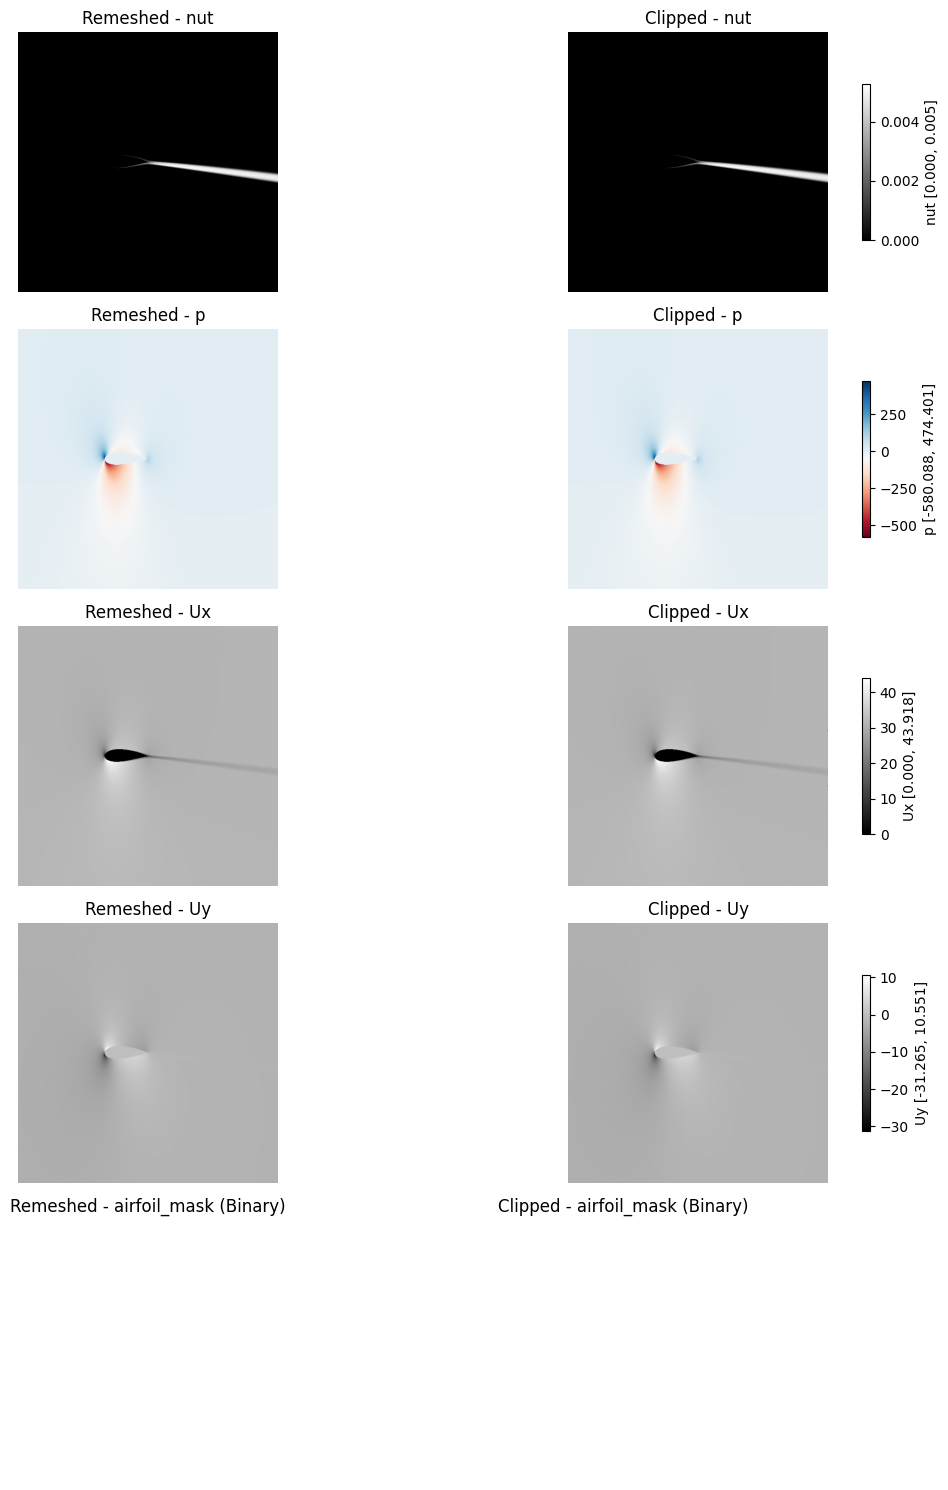


COMPARISON ANALYSIS
NUT:
  📊 VISUALIZATION: Shows range [0.000000, 0.005274]
  🔍 PHYSICAL DIFFERENCES:
    - Mean Absolute Error: 0.000000
    - RMSE: 0.000002
    - Relative Error: 0.04% of total range
  📱 NORMALIZED IMAGE DIFFERENCES (0-255 scale):
    - Mean Absolute Error: 0.01/255 (0.0%)
    - RMSE: 0.10/255 (0.0%)

P:
  📊 VISUALIZATION: Shows range [-580.088350, 474.401467]
  🔍 PHYSICAL DIFFERENCES:
    - Mean Absolute Error: 0.140656
    - RMSE: 0.288875
    - Relative Error: 0.03% of total range
  📱 NORMALIZED IMAGE DIFFERENCES (0-255 scale):
    - Mean Absolute Error: 0.04/255 (0.0%)
    - RMSE: 0.20/255 (0.1%)

UX:
  📊 VISUALIZATION: Shows range [0.000000, 43.918259]
  🔍 PHYSICAL DIFFERENCES:
    - Mean Absolute Error: 0.005173
    - RMSE: 0.096678
    - Relative Error: 0.22% of total range
  📱 NORMALIZED IMAGE DIFFERENCES (0-255 scale):
    - Mean Absolute Error: 0.03/255 (0.0%)
    - RMSE: 0.58/255 (0.2%)

UY:
  📊 VISUALIZATION: Shows range [-31.265326, 10.550596]
  🔍 PHYS

In [18]:
# Visualize comparison between remeshed and clipped meshes with CORRECT VALUE RANGES
if len(mesh_paths) > 0 and 'remeshed_images' in locals():
    
    variables = ['nut', 'p', 'Ux', 'Uy', 'airfoil_mask']
    n_vars = len(variables)
    
    # Create comparison plot (2 columns: remeshed vs clipped)
    fig, axes = plt.subplots(n_vars, 2, figsize=(12, 3*n_vars))
    
    for i, var in enumerate(variables):
        # Remeshed column
        if var in remeshed_data and var != 'airfoil_mask':
            # Use original data with global range for correct colorbar values
            global_min, global_max = global_ranges[var]
            im1 = axes[i, 0].imshow(remeshed_data[var], cmap='RdBu' if var == 'p' else 'gray', 
                                   vmin=global_min, vmax=global_max, origin='lower')
            axes[i, 0].set_title(f'Remeshed - {var}')
            axes[i, 0].axis('off')
        elif var == 'airfoil_mask' and var in remeshed_images:
            im1 = axes[i, 0].imshow(remeshed_images[var], cmap='gray', vmin=0, vmax=255, origin='lower')
            axes[i, 0].set_title(f'Remeshed - {var} (Binary)')
            axes[i, 0].axis('off')
        else:
            axes[i, 0].text(0.5, 0.5, f'{var}\nnot available', ha='center', va='center', transform=axes[i, 0].transAxes)
            axes[i, 0].axis('off')
        
        # Clipped column  
        if var in clipped_data and var != 'airfoil_mask':
            # Use original data with global range for correct colorbar values
            global_min, global_max = global_ranges[var]
            im2 = axes[i, 1].imshow(clipped_data[var], cmap='RdBu' if var == 'p' else 'gray', 
                                   vmin=global_min, vmax=global_max, origin='lower')
            axes[i, 1].set_title(f'Clipped - {var}')
            
            # Add colorbar with ACTUAL physical values
            cbar = plt.colorbar(im2, ax=axes[i, 1], shrink=0.6)
            cbar.set_label(f'{var} [{global_min:.3f}, {global_max:.3f}]')
            axes[i, 1].axis('off')
        elif var == 'airfoil_mask' and var in clipped_images:
            im2 = axes[i, 1].imshow(clipped_images[var], cmap='gray', vmin=0, vmax=255, origin='lower')
            axes[i, 1].set_title(f'Clipped - {var} (Binary)')
            axes[i, 1].axis('off')
        else:
            axes[i, 1].text(0.5, 0.5, f'{var}\nnot available', ha='center', va='center', transform=axes[i, 1].transAxes)
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison info
    print("\n" + "="*60)
    print("COMPARISON ANALYSIS")
    print("="*60)
    
    for var in ['nut', 'p', 'Ux', 'Uy']:
        if var in remeshed_images and var in clipped_images:
            # Calculate difference metrics on normalized images (for quantitative comparison)
            diff = remeshed_images[var].astype(np.float32) - clipped_images[var].astype(np.float32)
            mae = np.mean(np.abs(diff))
            rmse = np.sqrt(np.mean(diff**2))
            max_diff = np.max(np.abs(diff))
            
            # Also calculate physical value differences
            physical_diff = remeshed_data[var] - clipped_data[var]
            physical_mae = np.nanmean(np.abs(physical_diff))
            physical_rmse = np.sqrt(np.nanmean(physical_diff**2))
            physical_range = global_ranges[var][1] - global_ranges[var][0]
            
            print(f"{var.upper()}:")
            print(f"  📊 VISUALIZATION: Shows range [{global_ranges[var][0]:.6f}, {global_ranges[var][1]:.6f}]")
            print(f"  🔍 PHYSICAL DIFFERENCES:")
            print(f"    - Mean Absolute Error: {physical_mae:.6f}")
            print(f"    - RMSE: {physical_rmse:.6f}")
            print(f"    - Relative Error: {(physical_rmse/physical_range)*100:.2f}% of total range")
            print(f"  📱 NORMALIZED IMAGE DIFFERENCES (0-255 scale):")
            print(f"    - Mean Absolute Error: {mae:.2f}/255 ({mae/255*100:.1f}%)")
            print(f"    - RMSE: {rmse:.2f}/255 ({rmse/255*100:.1f}%)")
            print()
    
    print("🎯 KEY INSIGHTS:")
    print("• 📊 Visualization now shows ACTUAL physical values in colorbars")
    print("• 🔍 Physical differences show real-world accuracy between meshes")
    print("• 📱 Normalized differences are for image processing compatibility")
    print("• ✅ Same color ranges ensure fair visual comparison")

else:
    print("❌ No processed images available for comparison")

## 🎯 Important Note: Visualization vs. Saved Images

**VISUALIZATION (above plots):**
- Shows **actual physical values** in colorbars 
- nut: [0.000000, 0.005274]
- p: [-580.088350, 474.401467] 
- Ux: [0.000000, 43.918259]
- Uy: uses its own physical range

**SAVED IMAGES (for ML/processing):**
- Normalized to 0-255 for compatibility
- Same relative scaling preserved
- Use `remeshed_images` and `clipped_images` variables

This ensures you get both **human-readable visualizations** and **ML-ready normalized images**!

In [72]:

def compute_gradient(masked_img):
    """
    Compute the gradient of the masked image and plot the gradient magnitude and direction.
    
    Parameters:
    masked_img (numpy.ndarray): The masked image array.
    """
    # Compute gradients
    gx, gy = np.gradient(masked_img)

    # Compute gradient magnitude
    grad_mag = np.sqrt(gx**2 + gy**2) 

    # calculate the gradient direction
    grad_dir = np.arctan2(gy, gx)

    return grad_mag, grad_dir 

def compute_double_gradient(masked_img):
    """
    Compute the double gradient of the masked image and plot the gradient magnitude and direction.
    
    Parameters:
    masked_img (numpy.ndarray): The masked image array.
    """
    # Compute gradients
    gx, gy = np.gradient(masked_img)
    
    # Compute second derivatives
    gxx, gxy = np.gradient(gx)
    gyx, gyy = np.gradient(gy)

    # Compute gradient magnitude
    grad_mag = np.sqrt(gxx**2 + 2*gxy**2 + gyy**2)

    # calculate the gradient direction
    grad_dir = np.arctan2(gyx, gxx)

    return grad_mag, grad_dir

def compute_magnitude_over_gradient(masked_img):
    """
    Compute the double gradient of the masked image and plot the gradient magnitude and direction.
    
    Parameters:
    masked_img (numpy.ndarray): The masked image array.
    """ 
    # Compute gradients
    gx, gy = np.gradient(masked_img)
    grad_dir = np.arctan2(gy, gx)

    gx_dir, gy_dir = np.gradient(grad_dir)
    # Compute gradient magnitude
    grad_mag = np.sqrt(gx_dir**2 + gy_dir**2) 
    return grad_mag



In [73]:
remeshed_data['nut'][0, 0]

np.float64(3.083328703468169e-09)

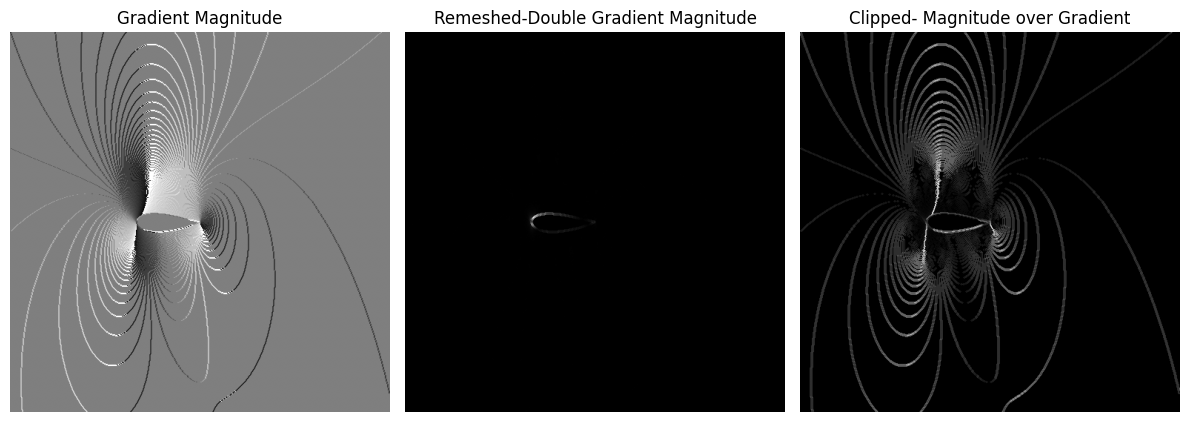

In [81]:
# test double gradient 
_, grad_dir_remeshed = compute_gradient(remeshed_images['p'])
grad_mag_remeshed, _ = compute_gradient(grad_dir_remeshed)

test_image, _ = compute_gradient(remeshed_images['p'])
test_image1, _ = compute_double_gradient(remeshed_images['p'])
test_image2 = compute_magnitude_over_gradient(remeshed_images['p'])

# Visualize double gradient results
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(grad_dir_remeshed, cmap='gray')
axes[0].set_title('Gradient Magnitude')
axes[0].axis('off')
axes[1].imshow(test_image1, cmap='gray')
axes[1].set_title('Remeshed-Double Gradient Magnitude')
axes[1].axis('off')
axes[2].imshow(test_image2, cmap='gray')
axes[2].set_title('Clipped- Magnitude over Gradient')
axes[2].axis('off')
plt.tight_layout()
plt.show()

### Hausdorff Distance 📏
It doesn't just count differing pixels; it measures the maximum distance between the two line shapes. It directly answers the question: "What is the worst-case deviation of my jagged line from the smooth one?"

How it Works:

Treat the white pixels in the reference image as Set A and in the low-res image as Set B.

For every point in Set B (the jagged line), it finds the closest point in Set A (the smooth line).

The Hausdorff Distance is the largest of all these minimum distances. It essentially finds the point on the jagged line that is farthest away from any part of the smooth line.

Metric: A distance value (in pixels). A larger Hausdorff Distance means the peaks of the "staircase" artifacts are further from the ideal smooth curve, indicating more severe jaggedness.

In [75]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(image1: np.ndarray, image2: np.ndarray) -> float:
    """
    Calculates the Hausdorff Distance between two binary images.

    The images are treated as sets of points, where white pixels (value 1 or True)
    are the points in the set.

    Args:
        image1: A 2D NumPy array representing the first binary image.
        image2: A 2D NumPy array representing the second binary image.

    Returns:
        The Hausdorff Distance between the two sets of points.
    """
    # Find the coordinates of all non-zero pixels
    coords1 = np.transpose(np.nonzero(image1))
    coords2 = np.transpose(np.nonzero(image2))

    if len(coords1) == 0 or len(coords2) == 0:
        return np.inf # Return infinity if one of the images is empty

    # The Hausdorff distance is the maximum of the two directed distances
    forward_dist = directed_hausdorff(coords1, coords2)[0]
    backward_dist = directed_hausdorff(coords2, coords1)[0]
    
    return max(forward_dist, backward_dist)

 
### Comparing Gradient Orientation Histograms 📊
This is the most direct way to solve the problem. Instead of just knowing that two shapes are different, this method tells you how their directional properties differ.

How it Works:

Compute Histograms: First, you compute the Gradient Orientation Histogram for your reference image and your test image, just as we discussed before. This gives you two distributions that represent the "flow" of each image.

Compare the Histograms: The crucial step is comparing these two histograms. A simple subtraction isn't very informative. A much better metric is the Earth Mover's Distance (EMD).

Metric: Earth Mover's Distance (EMD)
EMD, also known as the Wasserstein metric, calculates the minimum "work" required to transform one histogram into the other. Think of one histogram as a pile of dirt and the other as a hole; EMD is the cost of moving the dirt to fill the hole.

Why it's great for direction: It's "cross-bin" aware. It understands that changing an orientation from 10° to 20° (a small move) is much less "work" than changing it from 10° to 90° (a large move). This makes it perfect for comparing directional distributions.

A lower EMD score means the two images have very similar directional characteristics.

In [76]:
def calculate_orientation_histogram(image: np.ndarray, bins: int = 36) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates a magnitude-weighted histogram of gradient orientations.

    Args:
        image: A 2D NumPy array (grayscale image).
        bins: The number of orientation bins to use for the histogram.

    Returns:
        A tuple containing the normalized histogram and the bin edges.
    """
    # Ensure image is grayscale
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1. Calculate gradients using the Sobel operator
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # 2. Convert gradients to magnitude and orientation (in degrees)
    magnitude, angle_rad = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=False)
    angle_deg = np.rad2deg(angle_rad) # a 360-degree range

    # 3. Create the histogram, weighted by gradient magnitude
    # This ensures that strong edges contribute more to the histogram
    hist, bin_edges = np.histogram(
        angle_deg,
        bins=bins,
        range=(0, 360),
        weights=magnitude
    )

    # 4. Normalize the histogram to make it a probability distribution
    if np.sum(hist) > 0:
        hist = hist / np.sum(hist)
        
    return hist, bin_edges

import cv2
from scipy.stats import wasserstein_distance
def directional_distance_emd(image1: np.ndarray, image2: np.ndarray, bins: int = 36) -> float:
    """
    Calculates the Earth Mover's Distance (EMD) between the
    gradient orientation histograms of two images.

    A lower score indicates that the images have more similar
    directional characteristics.

    Args:
        image1: The first image as a NumPy array.
        image2: The second image as a NumPy array.
        bins: The number of orientation bins to use.

    Returns:
        The Earth Mover's Distance between the two orientation histograms.
    """
    # Calculate orientation histograms for both images
    hist1, bin_edges = calculate_orientation_histogram(image1, bins)
    hist2, _ = calculate_orientation_histogram(image2, bins)

    # Calculate the center of each bin for the EMD calculation
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate the Earth Mover's Distance (1D Wasserstein distance)
    # This measures the "work" required to transform one histogram into the other
    distance = wasserstein_distance(bin_centers, bin_centers, hist1, hist2)
    
    return distance

### Structure Tensor Comparison
For a very direct and mathematically rigorous comparison of orientation, you can use the Structure Tensor.

How it Works:

A structure tensor is a 2x2 matrix computed for every local neighborhood in the image. This matrix explicitly encodes information about the dominant orientation in that neighborhood.

You can then directly compare the tensors from the reference and test images at corresponding locations. For example, you can calculate the angular difference between their dominant orientations.

Metric: You could create a final score by averaging the angular difference in orientation across all corresponding patches in the two images. A lower average angular difference indicates a better directional match. This is more complex to implement but gives you the most direct possible measurement of directional disagreement.

In [77]:
def compute_orientation_field(image: np.ndarray, sigma: float = 3.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the local orientation angle and coherence for each pixel
    using the structure tensor.

    Args:
        image: A 2D NumPy array (grayscale image).
        sigma: The standard deviation of the Gaussian kernel used for averaging.
               A larger sigma considers a larger neighborhood.

    Returns:
        A tuple containing two 2D arrays:
        - orientation: The local angle in radians (from -PI/2 to PI/2).
        - coherence: A measure of how strong and unambiguous the orientation is
                     (from 0 for isotropic to 1 for perfect lines).
    """
    # Ensure image is grayscale
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 1. Calculate image gradients
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # 2. Compute the components of the structure tensor
    J11 = grad_x**2
    J22 = grad_y**2
    J12 = grad_x * grad_y

    # 3. Average the components over a local neighborhood using a Gaussian kernel
    J11 = cv2.GaussianBlur(J11, (0, 0), sigma)
    J22 = cv2.GaussianBlur(J22, (0, 0), sigma)
    J12 = cv2.GaussianBlur(J12, (0, 0), sigma)

    # 4. Calculate orientation angle (theta)
    # This is the angle of the eigenvector corresponding to the largest eigenvalue
    # The result is in radians, in the range [-PI/2, PI/2]
    orientation = 0.5 * np.arctan2(2 * J12, J11 - J22)
    
    # 5. (Optional but recommended) Calculate coherence
    # This helps ignore areas with no clear orientation
    # Eigenvalues lambda1, lambda2 can be calculated from the tensor components
    lambda1 = 0.5 * (J11 + J22 + np.sqrt(4 * J12**2 + (J11 - J22)**2))
    lambda2 = 0.5 * (J11 + J22 - np.sqrt(4 * J12**2 + (J11 - J22)**2))
    
    # Avoid division by zero in flat regions
    with np.errstate(divide='ignore', invalid='ignore'):
        coherence = ((lambda1 - lambda2) / (lambda1 + lambda2))**2
    coherence[np.isnan(coherence)] = 0 # Set coherence to 0 where sum of eigenvalues is 0
    
    return orientation, coherence


def structure_tensor_distance(image1: np.ndarray, image2: np.ndarray, coherence_threshold: float = 0.5) -> float:
    """
    Calculates the mean absolute angular difference between two images based on their
    structure tensors. Only regions with significant coherence in BOTH images are compared.

    Args:
        image1: The first image as a NumPy array.
        image2: The second image as a NumPy array.
        coherence_threshold: The minimum coherence value for an orientation to be considered valid.

    Returns:
        The average angular difference in degrees. A lower value means a better
        directional match.
    """
    orientation1, coherence1 = compute_orientation_field(image1)
    orientation2, coherence2 = compute_orientation_field(image2)

    # Create a mask for regions where BOTH images have strong, coherent orientation
    mask = (coherence1 > coherence_threshold) & (coherence2 > coherence_threshold)
    
    if np.sum(mask) == 0:
        return 90.0 # Return max possible difference if no common coherent regions exist

    # Calculate the absolute difference in orientation
    # The angles are in a range of PI, so their difference is also handled correctly
    angular_diff = np.abs(orientation1[mask] - orientation2[mask])
    
    # Handle the "wrap-around" nature of angles (e.g., diff between -89 deg and +89 deg)
    # The difference should be 2 degrees, not 178.
    angular_diff = np.minimum(angular_diff, np.pi - angular_diff)
    
    # Convert average difference from radians to degrees for easier interpretation
    mean_angular_diff_deg = np.rad2deg(np.mean(angular_diff))
    
    return mean_angular_diff_deg


# hausdorff_distance got values but also get Pixel based metrics

Hausdorff Distance: 0 to any; lower is better, 0 means identical
Directional Distance: 0 to 180; lower is better, 0 means identical
SSIM: -1 to 1.0; higher is better, 1 means identical
Structure Tensor Distance: 0 to 90; lower is better, 0 means identical


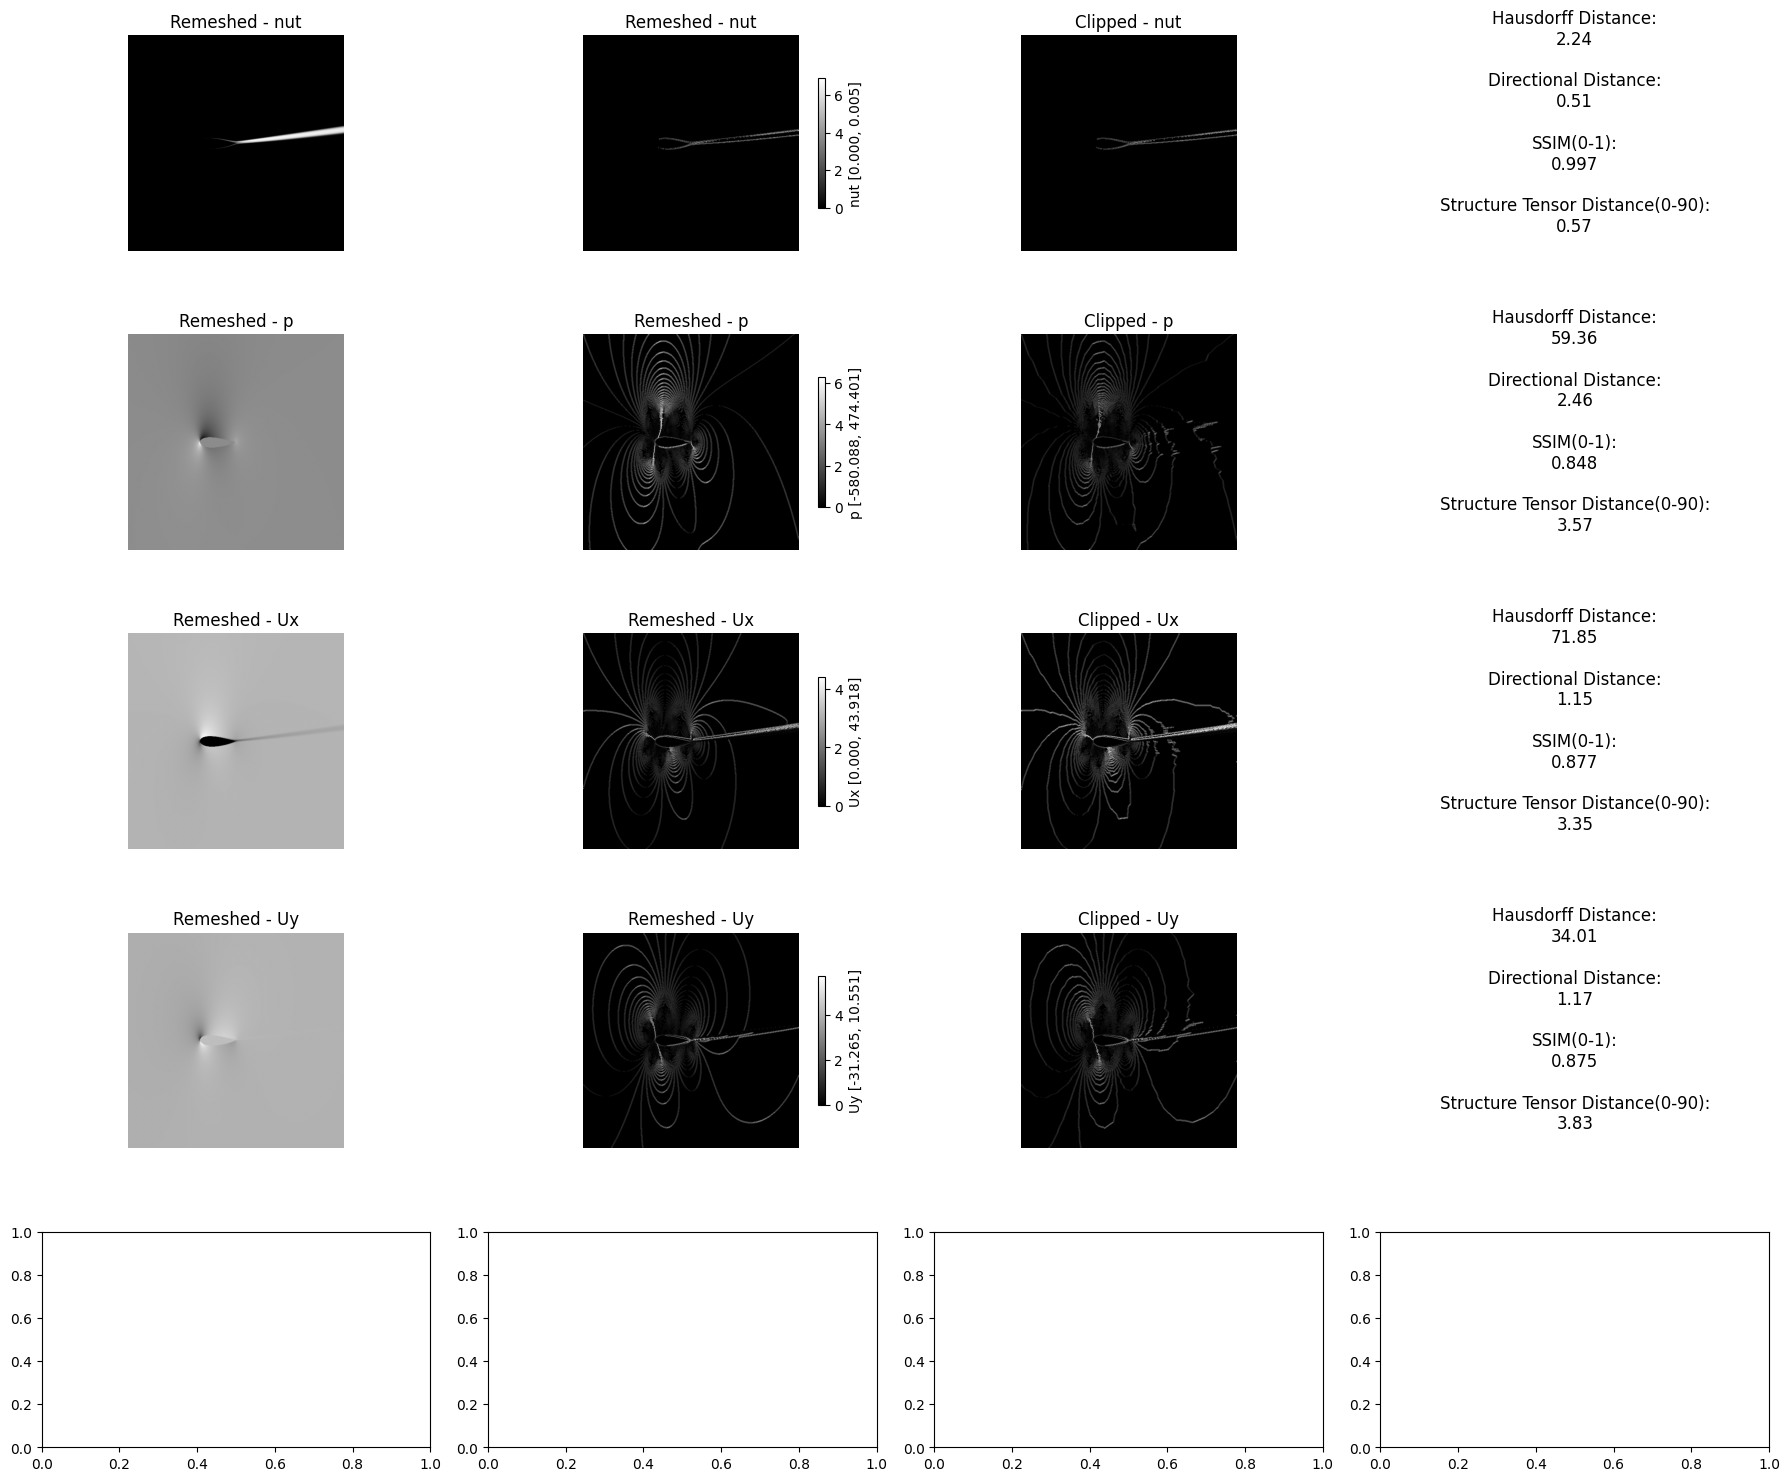

In [83]:
# Make sure skimage is installed

from skimage.metrics import structural_similarity as ssim

# Create comparison plot (3 columns: remeshed vs clipped vs scores)
fig, axes = plt.subplots(5, 4, figsize=(18, 3*5))
variables = ['nut', 'p', 'Ux', 'Uy' ]

print(f'Hausdorff Distance: 0 to any; lower is better, 0 means identical')
print(f'Directional Distance: 0 to 180; lower is better, 0 means identical')
print(f'SSIM: -1 to 1.0; higher is better, 1 means identical')
print(f'Structure Tensor Distance: 0 to 90; lower is better, 0 means identical')

for i, var in enumerate(variables):
    grad_mag_remeshed = grad_mag_clipped = None
    if var in remeshed_images :
        im1 = axes[i, 0].imshow(remeshed_images[var], cmap='gray')
        axes[i, 0].set_title(f'Remeshed - {var}')
        axes[i, 0].axis('off')

    # Remeshed column 
        global_min, global_max = global_ranges[var]
        _, grad_dir_remeshed = compute_gradient(remeshed_images[var])
        grad_mag_remeshed, _ = compute_gradient(grad_dir_remeshed)
        im1 = axes[i, 1].imshow(grad_mag_remeshed, cmap='gray')
        axes[i, 1].set_title(f'Remeshed - {var}')
        axes[i, 1].axis('off') 

    # Clipped column   
        global_min, global_max = global_ranges[var]
        _, grad_dir_clipped = compute_gradient(clipped_images[var])
        grad_mag_clipped, _ = compute_gradient(grad_dir_clipped)
        im2 = axes[i, 2].imshow(grad_mag_clipped, cmap='gray')
        axes[i, 2].set_title(f'Clipped - {var}')
        cbar = plt.colorbar(im2, ax=axes[i, 1], shrink=0.6)
        cbar.set_label(f'{var} [{global_min:.3f}, {global_max:.3f}]')
        axes[i, 2].axis('off')
    else:
        axes[i, 2].axis('off')

    # Compute and show scores in the 3rd column
    if grad_mag_remeshed is not None and grad_mag_clipped is not None:
        hausdorff = hausdorff_distance(grad_mag_remeshed, grad_mag_clipped)
        # hausdorff = 0
        directional = directional_distance_emd(grad_mag_remeshed, grad_mag_clipped)
        # SSIM expects 2D arrays, optionally scale to [0,1]
        ssim_score = ssim(
            grad_mag_remeshed.astype(np.float32), 
            grad_mag_clipped.astype(np.float32), 
            data_range=grad_mag_clipped.max() - grad_mag_clipped.min()
        )
        tensor_score = structure_tensor_distance(
            grad_dir_remeshed, grad_dir_clipped
        )
        score_text = ''.join([
            f'Hausdorff Distance:\n{hausdorff:.2f}\n\n',
            f'Directional Distance:\n{directional:.2f}\n\n',
            f'SSIM(0-1):\n{ssim_score:.3f}\n\n',
            f'Structure Tensor Distance(0-90):\n{tensor_score:.2f}\n\n'
        ])
    else:
        score_text = 'N/A'

    axes[i, 3].text(0.5, 0.5, score_text, ha='center', va='center', fontsize=12)
    # axes[i, 3].set_title('Scores')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Save comparison images with consistent naming
if len(mesh_paths) > 0 and 'remeshed_images' in locals():
    
    # Create output directories
    remeshed_dir = './comparison_images/sample_000/remeshed'
    clipped_dir = './comparison_images/sample_000/clipped'
    
    os.makedirs(remeshed_dir, exist_ok=True)
    os.makedirs(clipped_dir, exist_ok=True)
    
    print("\n" + "="*60)
    print("SAVING COMPARISON IMAGES")
    print("="*60)
    
    # Save remeshed images
    print("📁 Saving REMESHED images:")
    for var, image_data in remeshed_images.items():
        filename = f"{var}_remeshed.png"
        filepath = os.path.join(remeshed_dir, filename)
        if var == 'airfoil_mask':
            plt.imsave(filepath, image_data, cmap='gray')
        else:
            plt.imsave(filepath, image_data, cmap='viridis')
        print(f"  ✅ {filename}")
    
    # Save clipped images  
    print("\n📁 Saving CLIPPED images:")
    for var, image_data in clipped_images.items():
        filename = f"{var}_clipped.png"
        filepath = os.path.join(clipped_dir, filename)
        if var == 'airfoil_mask':
            plt.imsave(filepath, image_data, cmap='gray')
        else:
            plt.imsave(filepath, image_data, cmap='viridis')
        print(f"  ✅ {filename}")
    
    # Create side-by-side comparison images
    comparison_dir = './comparison_images/sample_000/side_by_side'
    os.makedirs(comparison_dir, exist_ok=True)
    
    print(f"\n📁 Saving SIDE-BY-SIDE comparisons:")
    for var in variables:
        if var in remeshed_images and var in clipped_images:
            # Create side-by-side comparison
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            if var == 'airfoil_mask':
                im1 = ax1.imshow(remeshed_images[var], cmap='gray', vmin=0, vmax=255, origin='lower')
                im2 = ax2.imshow(clipped_images[var], cmap='gray', vmin=0, vmax=255, origin='lower')
            else:
                im1 = ax1.imshow(remeshed_images[var], cmap='viridis', vmin=0, vmax=255, origin='lower')
                im2 = ax2.imshow(clipped_images[var], cmap='viridis', vmin=0, vmax=255, origin='lower')
                plt.colorbar(im2, ax=ax2, shrink=0.6)
            
            ax1.set_title(f'Remeshed - {var}')
            ax2.set_title(f'Clipped - {var}')
            ax1.axis('off')
            ax2.axis('off')
            
            plt.tight_layout()
            comparison_file = os.path.join(comparison_dir, f"{var}_comparison.png")
            plt.savefig(comparison_file, dpi=150, bbox_inches='tight')
            plt.close()
            
            print(f"  ✅ {var}_comparison.png")
    
    print(f"\n🎯 All comparison images saved!")
    print(f"📂 Remeshed: {remeshed_dir}")
    print(f"📂 Clipped: {clipped_dir}")
    print(f"📂 Comparisons: {comparison_dir}")

else:
    print("❌ No images to save")


SAVING COMPARISON IMAGES
📁 Saving REMESHED images:
  ✅ nut_remeshed.png
  ✅ p_remeshed.png
  ✅ Ux_remeshed.png
  ✅ Uy_remeshed.png
  ✅ airfoil_mask_remeshed.png

📁 Saving CLIPPED images:
  ✅ nut_clipped.png
  ✅ p_clipped.png
  ✅ Ux_clipped.png
  ✅ Uy_clipped.png
  ✅ airfoil_mask_clipped.png

📁 Saving SIDE-BY-SIDE comparisons:
  ✅ nut_comparison.png
  ✅ p_comparison.png
  ✅ Ux_comparison.png
  ✅ Uy_comparison.png
  ✅ airfoil_mask_comparison.png

🎯 All comparison images saved!
📂 Remeshed: ./comparison_images/sample_000/remeshed
📂 Clipped: ./comparison_images/sample_000/clipped
📂 Comparisons: ./comparison_images/sample_000/side_by_side


In [11]:
# TEMPLATE: Process all mesh pairs (uncomment to run)
"""
def process_all_mesh_pairs():
    print("="*80)
    print("PROCESSING ALL MESH PAIRS")
    print("="*80)
    
    for i, (remeshed_path, clipped_path) in enumerate(mesh_paths):
        print(f"\nProcessing sample {i:03d}/{len(mesh_paths)}...")
        
        try:
            # Process mesh pair
            remeshed_data, clipped_data, global_ranges = process_mesh_pair(remeshed_path, clipped_path, i)
            
            # Create consistently scaled images
            remeshed_images = {}
            clipped_images = {}
            
            for var in ['nut', 'p', 'Ux', 'Uy']:
                if var in global_ranges:
                    remeshed_images[var] = normalize_with_range(remeshed_data[var], global_ranges[var])
                    clipped_images[var] = normalize_with_range(clipped_data[var], global_ranges[var])
            
            # Process airfoil masks
            if 'implicit_distance' in remeshed_data:
                remeshed_images['airfoil_mask'] = create_airfoil_mask(remeshed_data['implicit_distance'])
            if 'implicit_distance' in clipped_data:
                clipped_images['airfoil_mask'] = create_airfoil_mask(clipped_data['implicit_distance'])
            
            # Save images
            sample_dir = f'./comparison_images/sample_{i:03d}'
            remeshed_dir = os.path.join(sample_dir, 'remeshed')
            clipped_dir = os.path.join(sample_dir, 'clipped')
            
            os.makedirs(remeshed_dir, exist_ok=True)
            os.makedirs(clipped_dir, exist_ok=True)
            
            # Save remeshed images
            for var, image_data in remeshed_images.items():
                filename = f"{var}_remeshed.png"
                filepath = os.path.join(remeshed_dir, filename)
                if var == 'airfoil_mask':
                    plt.imsave(filepath, image_data, cmap='gray')
                else:
                    plt.imsave(filepath, image_data, cmap='viridis')
            
            # Save clipped images
            for var, image_data in clipped_images.items():
                filename = f"{var}_clipped.png"
                filepath = os.path.join(clipped_dir, filename)
                if var == 'airfoil_mask':
                    plt.imsave(filepath, image_data, cmap='gray')
                else:
                    plt.imsave(filepath, image_data, cmap='viridis')
            
            print(f"✅ Saved sample {i:03d}")
            
        except Exception as e:
            print(f"❌ Error processing sample {i:03d}: {e}")
            continue
    
    print(f"\n🎯 Finished processing {len(mesh_paths)} mesh pairs!")

# Uncomment the line below to process all mesh pairs:
# process_all_mesh_pairs()
"""

print("\n" + "="*80)
print("🚀 READY FOR BATCH PROCESSING!")
print("="*80)
print("✅ Successfully processed first mesh pair as test")
print("📝 To process all mesh pairs:")
print("   1. Uncomment the last line in the cell above")
print("   2. Run the cell")
print("   3. Wait for all samples to be processed")
print(f"\n📊 Total mesh pairs available: {len(mesh_paths)}")
print("🎯 Each pair will have consistent color scaling for accurate comparison!")


🚀 READY FOR BATCH PROCESSING!
✅ Successfully processed first mesh pair as test
📝 To process all mesh pairs:
   1. Uncomment the last line in the cell above
   2. Run the cell
   3. Wait for all samples to be processed

📊 Total mesh pairs available: 11
🎯 Each pair will have consistent color scaling for accurate comparison!


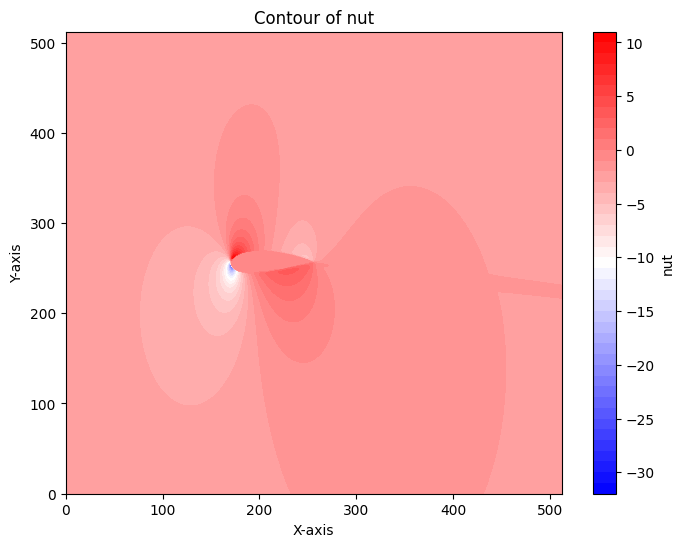

In [10]:
# plotting differenct plots
mesh_data = remeshed_data['Uy']

# plot contour of nut
plt.figure(figsize=(8, 6))
plt.contourf(mesh_data, levels=50, cmap='bwr')
plt.colorbar(label='nut')
plt.title('Contour of nut')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

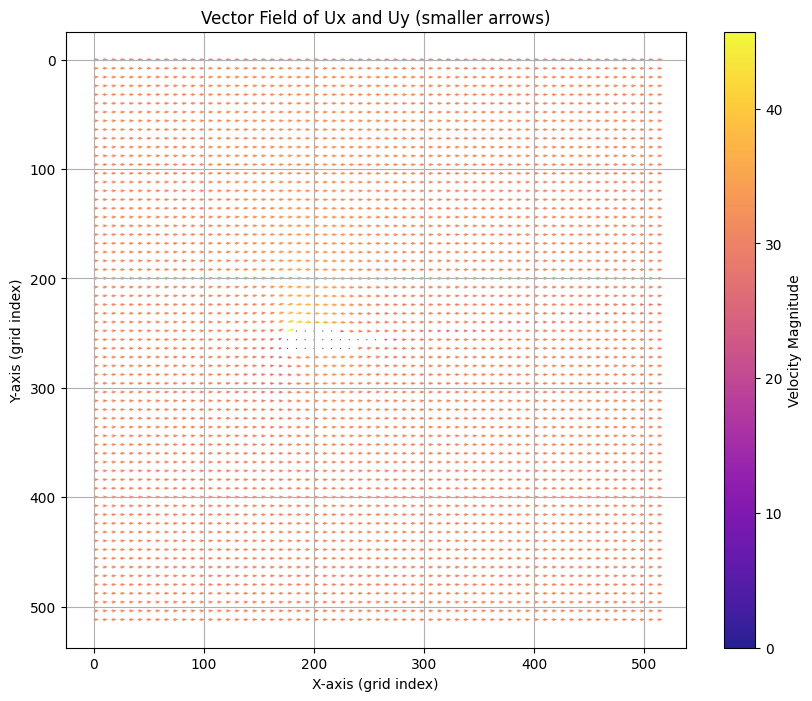

In [15]:
# Improved vector field plot: smaller arrows and arrowheads for clarity

Uy = remeshed_data['Uy']
Ux = remeshed_data['Ux']

ny, nx = Uy.shape
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Subsample for clarity
step = max(ny // 64, 1)
X_sub = X[::step, ::step]
Y_sub = Y[::step, ::step]
Ux_sub = Ux[::step, ::step]
Uy_sub = Uy[::step, ::step]

# Compute magnitude for coloring
magnitude = np.sqrt(Ux_sub**2 + Uy_sub**2)

plt.figure(figsize=(10, 8))
# Use smaller width and arrowhead parameters for less obtrusive arrows
# Q = plt.quiver(
#     X_sub, Y_sub, Ux_sub, Uy_sub, magnitude,
#     angles='xy', scale=None, width=0.003, cmap='viridis',
#     headwidth=2, headlength=3, headaxislength=2
#     )
Q = plt.quiver(
    X_sub, Y_sub, Ux_sub, Uy_sub, magnitude,
    angles='xy', scale=None, width=0.002, cmap='plasma',
    headwidth=3, headlength=4, headaxislength=3, alpha=0.9
    )
plt.colorbar(Q, label='Velocity Magnitude')
plt.title('Vector Field of Ux and Uy (smaller arrows)')
plt.xlabel('X-axis (grid index)')
plt.ylabel('Y-axis (grid index)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

C_D,C_L,angle_of_attack,inlet_velocity
1.031418489975951050e-02,8.565651227381053667e-01,8.421213640872640682e-02,9.350000000000000000e+01

C_D,C_L,angle_of_attack,inlet_velocity
1.031418489975951050e-02,8.565651227381053667e-01,8.421213640872640682e-02,9.350000000000000000e+01


In [8]:
import os
import pandas as pd

data_remeshed_path = './AirfRANS_remeshed'
data_clipped_path = './AirfRANS_clipped'


# loop through all mesh pairs
scalar_vals = []
for sample_folder in os.listdir(data_remeshed_path):
    if not os.path.isdir(os.path.join(data_remeshed_path, sample_folder)):
        continue  # Skip if not a directory
    scalar_obj = {}
    scalar_csv_remeshed = pd.read_csv(os.path.join(data_remeshed_path, sample_folder, 'scalars.csv'))
    scalar_csv_clipped = pd.read_csv(os.path.join(data_clipped_path, sample_folder, 'scalars.csv')) 
    scalar_obj['CD_diff'] = float(scalar_csv_remeshed['C_D']) - float(scalar_csv_clipped['C_D'])
    scalar_obj['CL_diff'] = float(scalar_csv_remeshed['C_L']) - float(scalar_csv_clipped['C_L'])
     
    scalar_vals.append(scalar_obj)
# Print the scalar values for each sample
for i, scalar in enumerate(scalar_vals):
    print(f"Sample {i+1}: CD_diff = {scalar['CD_diff']}, CL_diff = {scalar['CL_diff']}")

Sample 1: CD_diff = 0.0, CL_diff = 0.0
Sample 2: CD_diff = 0.0, CL_diff = 0.0
Sample 3: CD_diff = 0.0, CL_diff = 0.0
Sample 4: CD_diff = 0.0, CL_diff = 0.0
Sample 5: CD_diff = 0.0, CL_diff = 0.0
Sample 6: CD_diff = 0.0, CL_diff = 0.0
Sample 7: CD_diff = 0.0, CL_diff = 0.0
Sample 8: CD_diff = 0.0, CL_diff = 0.0
Sample 9: CD_diff = 0.0, CL_diff = 0.0
Sample 10: CD_diff = 0.0, CL_diff = 0.0
Sample 11: CD_diff = 0.0, CL_diff = 0.0


/var/folders/kv/dhtpsyc96bxbf6h3xtp79xnc0000gn/T/ipykernel_17078/3530880923.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  scalar_obj['CD_diff'] = float(scalar_csv_remeshed['C_D']) - float(scalar_csv_clipped['C_D'])
/var/folders/kv/dhtpsyc96bxbf6h3xtp79xnc0000gn/T/ipykernel_17078/3530880923.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  scalar_obj['CL_diff'] = float(scalar_csv_remeshed['C_L']) - float(scalar_csv_clipped['C_L'])
/var/folders/kv/dhtpsyc96bxbf6h3xtp79xnc0000gn/T/ipykernel_17078/3530880923.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  scalar_obj['CD_diff'] = float(scalar_csv_remeshed['C_D']) - float(scalar_csv_clipped['C_D'])
/var/folders/kv/dhtpsyc96bxbf6h3xtp79

In [ ]:
def process_mesh_pair(remeshed_path, clipped_path):
    """
    Process a pair of remeshed and clipped meshes with consistent scaling
    Args:
        remeshed_path (str): Path to remeshed mesh file
        clipped_path (str): Path to clipped mesh file  
    Returns:
        tuple: (remeshed_data, clipped_data, global_ranges) for consistent scaling
    """
    
    def extract_mesh_data(filepath, mesh_type):
        """Extract data from a single mesh file"""
        print(f"\nProcessing {mesh_type} mesh: {os.path.basename(filepath)}")
        
        # Read the mesh
        reader = pv.CGNSReader(filepath)
        reader.load_boundary_patch = False
        mesh = reader.read().combine()
        
        # Get bounds and create sampling plane
        bounds = mesh.bounds
        x_min, x_max, y_min, y_max, z_min, z_max = bounds
        resolution = 512
        
        plane = pv.Plane(center=[(x_min + x_max)/2, (y_min + y_max)/2, 0], 
                        direction=[0, 0, 1], 
                        i_size=x_max - x_min, 
                        j_size=y_max - y_min, 
                        i_resolution=resolution, 
                        j_resolution=resolution)
        
        # Sample the data
        sampled_mesh = plane.sample(mesh)
        n_points = sampled_mesh.n_points
        actual_resolution = int(np.sqrt(n_points))
        
        print(f"  Available arrays: {sampled_mesh.array_names}")
        print(f"  Resolution: {actual_resolution}x{actual_resolution}")
        
        # Extract data arrays
        data_dict = {}
        for array_name in ['nut', 'p', 'Ux', 'Uy', 'implicit_distance']:
            if array_name in sampled_mesh.array_names:
                data = sampled_mesh[array_name]
                
                # Reshape data
                if len(data) == actual_resolution * actual_resolution:
                    data = data.reshape(actual_resolution, actual_resolution)
                else:
                    # Interpolate to regular grid
                    from scipy.interpolate import griddata
                    points = sampled_mesh.points
                    x, y = points[:, 0], points[:, 1]
                    xi = np.linspace(x.min(), x.max(), resolution)
                    yi = np.linspace(y.min(), y.max(), resolution)
                    Xi, Yi = np.meshgrid(xi, yi)
                    data = griddata((x, y), data, (Xi, Yi), method='linear')
                
                data_dict[array_name] = data
                print(f"  {array_name}: range [{np.nanmin(data):.6f}, {np.nanmax(data):.6f}]")
        
        return data_dict, bounds
    
    # Process both meshes
    remeshed_data, remeshed_bounds = extract_mesh_data(remeshed_path, "REMESHED")
    clipped_data, clipped_bounds = extract_mesh_data(clipped_path, "CLIPPED")
    
    # Calculate global ranges for consistent scaling
    global_ranges = {}
    for var in ['nut', 'p', 'Ux', 'Uy']:
        if var in remeshed_data and var in clipped_data:
            # Find global min/max across both meshes
            remeshed_vals = remeshed_data[var]
            clipped_vals = clipped_data[var]
            
            global_min = min(np.nanmin(remeshed_vals), np.nanmin(clipped_vals))
            global_max = max(np.nanmax(remeshed_vals), np.nanmax(clipped_vals))
            
            global_ranges[var] = (global_min, global_max)
            print(f"\nGlobal range for {var}: [{global_min:.6f}, {global_max:.6f}]")
    
    return remeshed_data, clipped_data, global_ranges

def normalize_with_range(data, global_range):
    """Normalize data using global range for consistent scaling"""
    global_min, global_max = global_range
    if global_max == global_min:
        return np.zeros_like(data, dtype=np.uint8)
    normalized = (data - global_min) / (global_max - global_min)
    return (normalized * 255).astype(np.uint8)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.DataFrame(columns=[
#     'p_path', 'nut_path', 'Ux_path', 'Uy_path', 
#     'p_label', 'nut_label', 'Ux_label', 'Uy_label',
#     'C_D', 'C_L', 'angle_of_attack', 'inlet_velocity'
#     'L_D_ratio', "base_label"
#     ])
all_data = []
output_dir = 'raw_data_images'
os.makedirs(output_dir, exist_ok=True)
for i, (remeshed_mesh_path, clipped_mesh_path, remeshed_scalar_path, clipped_scalar_path) in enumerate(mesh_paths):
    label = None
    data_object = {
        'p_path': None,
        'nut_path': None,
        'Ux_path': None,
        'Uy_path': None,
        'p_label': label,
        'nut_label': label,
        'Ux_label': label,
        'Uy_label': label,
        'C_D': None,
        'C_L': None,
        'angle_of_attack': None,
        'inlet_velocity': None
    }
    data = pd.read_csv(remeshed_scalar_path)

    data_object['C_D'] = data['C_D'].values[0]
    data_object['C_L'] = data['C_L'].values[0]
    data_object['angle_of_attack'] = data['angle_of_attack'].values[0]
    data_object['inlet_velocity'] = data['inlet_velocity'].values[0]

    data_object['L_D_ratio'] = data_object['C_D']/data_object['C_L']
    
    
    # Process both meshes
    remeshed_data, clipped_data, global_ranges = process_mesh_pair(remeshed_mesh_path, clipped_mesh_path)
    
    # Create consistently scaled images
    remeshed_images = {}
    clipped_images = {}

    # Process flow variables with consistent scaling
    for var in ['nut', 'p', 'Ux', 'Uy']:
        if var in global_ranges:
            remeshed_images[var] = normalize_with_range(remeshed_data[var], global_ranges[var])
            clipped_images[var] = normalize_with_range(clipped_data[var], global_ranges[var])
    
    for var, image in remeshed_images.items():
        filename = f'{i}_remeshed_{var}.png'
        file_path = os.path.join(output_dir, filename)
        plt.imsave(file_path, image, cmap='RdBu') 
        data_object[var + '_path'] = file_path

    # Save clipped images
    for var, image in clipped_images.items():
        filename = f'{i}_clipped_{var}.png'
        file_path = os.path.join(output_dir, filename)
        plt.imsave(file_path, image, cmap='RdBu') 
        data_object[var + '_path'] = file_path
    
    # df = df.append(data_object, ignore_index=True)
    all_data.append(data_object)

# Create DataFrame from all collected data
df = pd.DataFrame(all_data)
df['base_label'] = pd.qcut(df['L_D_ratio'], q=3,
                                  labels=['low_efficiency', 'medium_efficiency', 'high_efficiency'])



# Create the four unique label columns
for img_type in ['p', 'nut', 'ux', 'uy']:
    df[f'{img_type}_label'] = img_type + '_' + df['base_label'].astype(str)



In [ ]:
# save the DataFrame to a CSV file
df.to_csv('mesh_data_summary.csv', index=False)

In [ ]:
# read the CSV file as a DataFrame
df = pd.read_csv('mesh_data_summary.csv')